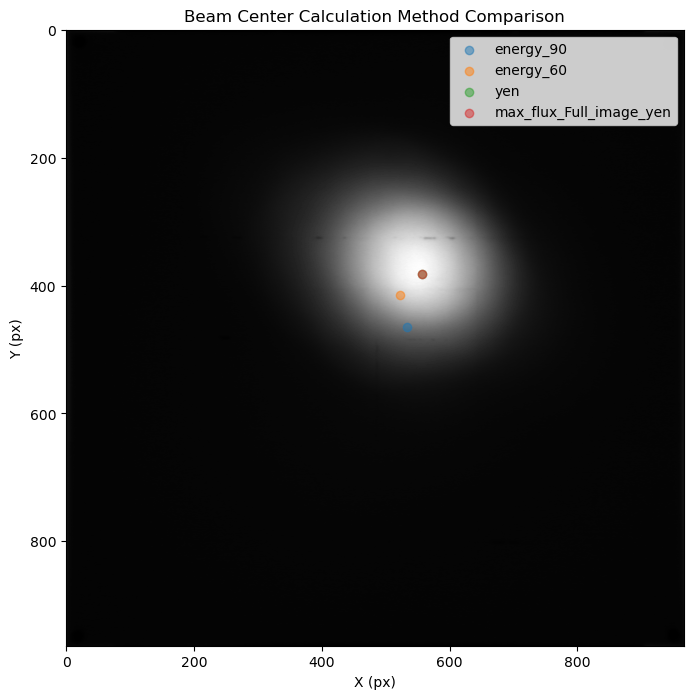

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
from skimage.filters import threshold_yen


image_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\PSA-CIEMAT\data\Test tracking H1605 to BCS people"
image_file_name = "H1605 TRK 24-01-2025 Start_11.57.00 End_15.57.37 Frames-48 TFOV.tif"
image_file_path = os.path.join(image_folder, image_file_name)
images = imread(image_file_path)

image_0 = images[0]

target_x_low = 183
target_x_high = 1150
target_y_low = 27
target_y_high = 991

image_0 = image_0[target_y_low:target_y_high, target_x_low:target_x_high]


centroid_file = os.path.join(os.getcwd(), "results", "BCS_RR_on_timestamp_1.csv")
centroid_df = pd.read_csv(centroid_file, index_col=0)

beam_center_calculation_method = ["energy_90", "energy_60", "yen", "max_flux_Full_image_yen"]
x_column_name = "Beam Center X (px)"
y_column_name = "Beam Center Y (px)"

plt.figure(figsize=(8, 8))
plt.imshow(image_0, cmap="gray")
x_center_buffer = []
y_center_buffer = []
for method in beam_center_calculation_method:
    full_method_name = f"centroid_Full_image_{method}" if method != "max_flux_Full_image_yen" else "centroid_Full_image_yen"
    x_val = centroid_df.loc[full_method_name, x_column_name]
    y_val = centroid_df.loc[full_method_name, y_column_name]
    plt.scatter(x_val, y_val, label=method, alpha=0.5)
    x_center_buffer.append(x_val)
    y_center_buffer.append(y_val)

plt.title("Beam Center Calculation Method Comparison")
plt.xlabel("X (px)")
plt.ylabel("Y (px)")
plt.legend()
plt.show()







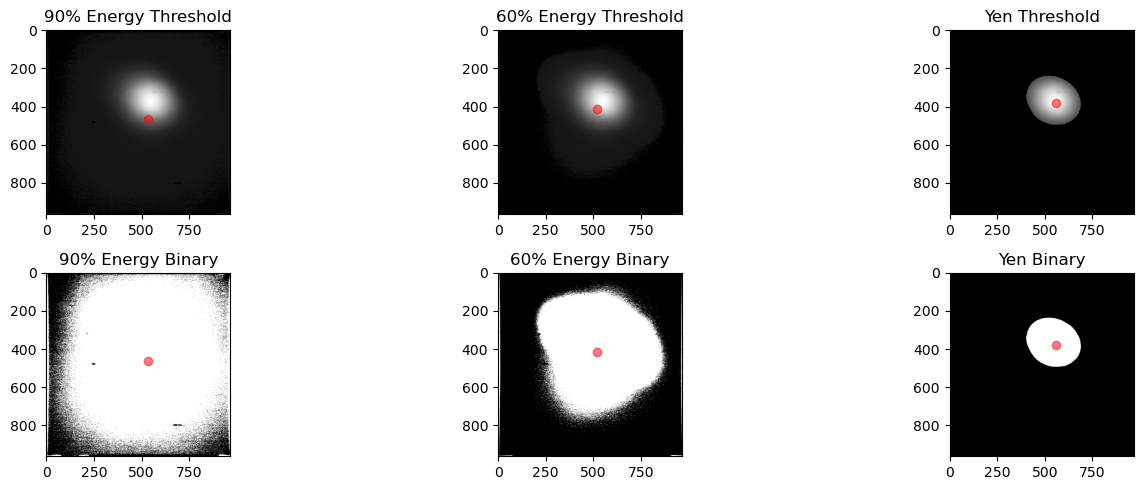

In [2]:
def find_theshold_with_energy(img_input, energy_level):
    sorted_data = np.sort(img_input.flatten())[::-1]
    cumulative_sum = np.cumsum(sorted_data)
    total_sum = cumulative_sum[-1]
    threshold_index = np.searchsorted(cumulative_sum, total_sum * energy_level / 100.0)
    threshold_value = sorted_data[threshold_index]
    return threshold_value

threshold_yen = threshold_yen(image_0)
threshold_90 = find_theshold_with_energy(image_0, 90)
threshold_60 = find_theshold_with_energy(image_0, 60)

img_threshold_90_binary = image_0 > threshold_90
img_threshold_60_binary = image_0 > threshold_60
img_threshold_yen_binary = image_0 > threshold_yen
img_threhsold_90 = image_0.copy()
img_threhsold_90[~img_threshold_90_binary] = 0
img_threhsold_60 = image_0.copy()
img_threhsold_60[~img_threshold_60_binary] = 0
img_threshold_yen = image_0.copy()
img_threshold_yen[~img_threshold_yen_binary] = 0

fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0, 0].imshow(img_threhsold_90, cmap="gray")
ax[0, 0].scatter(x_center_buffer[0], y_center_buffer[0], label="90% Energy", color="red", alpha=0.5)
ax[0, 0].set_title("90% Energy Threshold")
ax[0, 1].imshow(img_threhsold_60, cmap="gray")
ax[0, 1].scatter(x_center_buffer[1], y_center_buffer[1], label="60% Energy", color="red", alpha=0.5)
ax[0, 1].set_title("60% Energy Threshold")
ax[1, 0].imshow(img_threshold_90_binary, cmap="gray")
ax[1, 0].scatter(x_center_buffer[0], y_center_buffer[0], label="90% Energy Binary", color="red", alpha=0.5)
ax[1, 0].set_title("90% Energy Binary")
ax[1, 1].imshow(img_threshold_60_binary, cmap="gray")
ax[1, 1].scatter(x_center_buffer[1], y_center_buffer[1], label="60% Energy Binary", color="red", alpha=0.5)
ax[1, 1].set_title("60% Energy Binary")
ax[0, 2].imshow(img_threshold_yen, cmap="gray")
ax[0, 2].scatter(x_center_buffer[2], y_center_buffer[2], label="Yen Threshold", color="red", alpha=0.5)
ax[0, 2].set_title("Yen Threshold")
ax[1, 2].imshow(img_threshold_yen_binary, cmap="gray")
ax[1, 2].scatter(x_center_buffer[2], y_center_buffer[2], label="Yen Binary", color="red", alpha=0.5)
ax[1, 2].set_title("Yen Binary")
plt.tight_layout()
plt.show()

